<a href="https://colab.research.google.com/github/ashaaher/Emerging-Technologies/blob/master/Assignment%202/Assignment_2_Part_1/B_LinearClassifier_GradientTape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Building Linear Classifier using GradientTape and low level tensorflow code.**

### **Understanding of GradientTape:**


*   Trainable variables are watched by default because computing the gradient of loss with regards to list of trainable variables is the most common use case 
of gradient tape.

*   GradientTape :GradientTape is the API through which we can leverage Tensorflow's powerful automatic differnciation capabilities

*   Python can record the operations that runs inside the Tensorflow in the form of computation graph.

*   We can use this graph to retrieve the gradient of any output with respect to any variable or set of variables.

###Installing Tensorflow

In [ ]:
!pip install tensorflow==2.0.0

### Importing tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.0.0


### Creating the linear classifier variables

In [ ]:
input_dim = 2
output_dim = 1
learning_rate = 0.01

### Weight and bias matrix

In [ ]:
# This is our weight matrix
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))


### The forward pass function

In [ ]:
def compute_predictions(features):
  return tf.matmul(features, w) + b


### The mean squared error loss function

In [ ]:
def compute_loss(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions))


### The training step function

In [ ]:
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

### Generating some artificial data to demonstrate the model

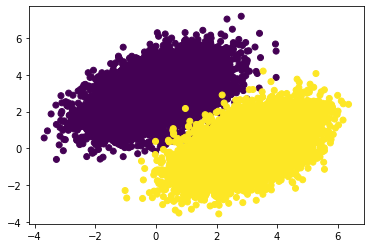

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

### Generating two classes of random points in 2D plane
# Prepare a dataset.
num_samples = 10000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)

### Generating the corrosponding targets (0 and 1)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])

###Training the linear regression

Training the linear regression by iterating over batch-by-batch over the data and repeatedly calling training step function called  'train_on_batch'

In [ ]:
# Shuffle the data.
indices = np.random.permutation(len(features))
features = features[indices]
labels = labels[indices]

# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

### The batch training loop 
for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 0.0557
Epoch 1: last batch loss = 0.0604
Epoch 2: last batch loss = 0.0472
Epoch 3: last batch loss = 0.0276
Epoch 4: last batch loss = 0.0309
Epoch 5: last batch loss = 0.0239
Epoch 6: last batch loss = 0.0392
Epoch 7: last batch loss = 0.0216
Epoch 8: last batch loss = 0.0246
Epoch 9: last batch loss = 0.0272


### Inference 

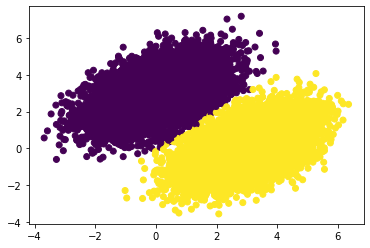

In [ ]:
predictions = compute_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

### Checking code execution Speed

In [ ]:
import time

t0 = time.time()
for epoch in range(20):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
t_end = time.time() - t0
print('Time per epoch: %.3f s' % (t_end / 20,))

Time per epoch: 0.154 s


We can increase the speed of above code execution by using tensorflows built in function called tf.function.
we will compile same Training step function which we compiled above(train_on_batch) with tf.function added to it.

In [ ]:
@tf.function
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss  

Checking code execution speed after tf.function

In [ ]:
t0 = time.time()
for epoch in range(20):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
t_end = time.time() - t0
print('Time per epoch: %.3f s' % (t_end / 20,))

Time per epoch: 0.088 s


As we can see there is 40% reduction in execution time after tf.function implementation. In general when the model is bigger,we can leverage static graphs for greater speedup.
